In [10]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from PIL import Image
import wandb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import io

from torchvision.utils import make_grid


In [11]:
!wandb login 6001619563748a57b4114b0bb090fd4129ba6122

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [13]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10, filter_counts=None, filter_sizes=None, 
                 activation_func=nn.ReLU(), fc_neurons=512, use_batch_norm=True, 
                 dropout_rate=0.2):
        super(CNNModel, self).__init__()
        
        # Default values if none provided
        if filter_counts is None:
            filter_counts = [32, 64, 128, 256, 512]
        if filter_sizes is None:
            filter_sizes = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
        
        # Input channels (RGB)
        in_channels = 3
        
        # Store layers
        self.features = nn.ModuleList()
        
        # Create 5 conv-activation-maxpool blocks
        for i in range(5):
            # Add convolution layer
            conv = nn.Conv2d(in_channels, filter_counts[i], kernel_size=filter_sizes[i], padding='same')
            self.features.append(conv)
            
            # Add batch normalization if specified
            if use_batch_norm:
                self.features.append(nn.BatchNorm2d(filter_counts[i]))
                
            # Add activation function
            self.features.append(activation_func)
            
            # Add max pooling layer
            self.features.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            # Update in_channels for the next layer
            in_channels = filter_counts[i]
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(filter_counts[-1], fc_neurons),activation_func,
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(fc_neurons, num_classes)
        )
        
    def forward(self, x):
        # Pass input through feature layers
        for layer in self.features:
            x = layer(x)
        
        # Global average pooling
        x = self.adaptive_pool(x)
        
        # Flatten the tensor
        x = torch.flatten(x, 1)
        
        # Pass through classifier
        x = self.classifier(x)
        
        return x

In [14]:



# Modified data preparation for train/val only
def get_train_val_loaders(data_dir, train_transform, val_transform, batch_size=64, val_split=0.2):
    full_train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    targets = np.array(full_train_dataset.targets)
    classes = full_train_dataset.classes

    # Stratified split
    train_indices, val_indices = [], []
    for class_idx in range(len(classes)):
        class_indices = np.where(targets == class_idx)[0]
        n_val = int(len(class_indices) * val_split)
        np.random.shuffle(class_indices)
        val_indices.extend(class_indices[:n_val])
        train_indices.extend(class_indices[n_val:])

    # Subsets
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_train_dataset, val_indices)
    val_dataset.dataset.transform = val_transform  # Apply val transform

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, classes

In [15]:
best_config = {
    'learning_rate': 0.001,
    'train_batch_size': 64,
    'epochs': 20,
    'activation': 'relu',
    'filter_counts': [32, 32, 32, 32, 32],
    'shape_of_filters_conv': [(3,3),(3,3),(3,3),(5,5),(7,7)],
    'fc_layer': 256,
    'batch_norm_use': True,
    'dropout': 0,
    'data_aug': True
}

In [20]:
# Function to get activation function
def get_activation(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'gelu':
        return nn.GELU()
    elif name == 'silu':
        return nn.SiLU()
    elif name == 'mish':
        return nn.Mish()
    else:
        return nn.ReLU()  # Default

In [16]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 160

In [17]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) if best_config['data_aug'] else transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [19]:
# Load data
data_dir = '/kaggle/input/naturalist/inaturalist_12K'
train_loader, val_loader, classes = get_train_val_loaders(
    data_dir, train_transform, val_transform, 
    batch_size=best_config['train_batch_size']
)


In [22]:

# Initialize model
activation =get_activation('relu')

In [27]:
wandb.init(project="inaturalist-cnn")


wandb: Currently logged in as: cs24m025 (manglesh-patidar-cs24m025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [23]:

model = CNNModel(
    num_classes=len(classes),
    filter_counts=best_config['filter_counts'],
    filter_sizes=best_config['shape_of_filters_conv'],
    activation_func=activation,
    fc_neurons=best_config['fc_layer'],
    use_batch_norm=best_config['batch_norm_use'],
    dropout_rate=best_config['dropout']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [24]:


# Training loop
best_val_acc = 0.0
for epoch in range(best_config['epochs']):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

Epoch 1 [Val]: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Epoch 1: Train Loss: 2.1275, Acc: 0.2291 | Val Loss: 2.0440, Acc: 0.2701
New best model saved with Val Acc: 0.2701


Epoch 2 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 2: Train Loss: 2.0108, Acc: 0.2791 | Val Loss: 2.0431, Acc: 0.2621


Epoch 3 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


Epoch 3: Train Loss: 1.9457, Acc: 0.3103 | Val Loss: 1.9692, Acc: 0.2896
New best model saved with Val Acc: 0.2896


Epoch 4 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch 4: Train Loss: 1.8878, Acc: 0.3250 | Val Loss: 1.9360, Acc: 0.3047
New best model saved with Val Acc: 0.3047


Epoch 5 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Epoch 5: Train Loss: 1.8409, Acc: 0.3514 | Val Loss: 1.9130, Acc: 0.3207
New best model saved with Val Acc: 0.3207


Epoch 6 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Epoch 6: Train Loss: 1.7980, Acc: 0.3619 | Val Loss: 1.9113, Acc: 0.3272
New best model saved with Val Acc: 0.3272


Epoch 7 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


Epoch 7: Train Loss: 1.7614, Acc: 0.3761 | Val Loss: 1.8714, Acc: 0.3297
New best model saved with Val Acc: 0.3297


Epoch 8 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Epoch 8: Train Loss: 1.7092, Acc: 0.3997 | Val Loss: 1.8996, Acc: 0.3277


Epoch 9 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 9: Train Loss: 1.6789, Acc: 0.4060 | Val Loss: 1.9945, Acc: 0.3242


Epoch 10 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 10: Train Loss: 1.6447, Acc: 0.4171 | Val Loss: 1.8497, Acc: 0.3532
New best model saved with Val Acc: 0.3532


Epoch 11 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch 11: Train Loss: 1.6017, Acc: 0.4348 | Val Loss: 1.8463, Acc: 0.3722
New best model saved with Val Acc: 0.3722


Epoch 12 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


Epoch 12: Train Loss: 1.5824, Acc: 0.4429 | Val Loss: 1.7465, Acc: 0.3842
New best model saved with Val Acc: 0.3842


Epoch 13 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Epoch 13: Train Loss: 1.5377, Acc: 0.4571 | Val Loss: 1.8171, Acc: 0.3812


Epoch 14 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


Epoch 14: Train Loss: 1.5067, Acc: 0.4720 | Val Loss: 1.8504, Acc: 0.3557


Epoch 15 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


Epoch 15: Train Loss: 1.4564, Acc: 0.4935 | Val Loss: 1.7823, Acc: 0.3942
New best model saved with Val Acc: 0.3942


Epoch 16 [Val]: 100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


Epoch 16: Train Loss: 1.4334, Acc: 0.5009 | Val Loss: 1.8233, Acc: 0.3842


Epoch 17 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Epoch 17: Train Loss: 1.3037, Acc: 0.5481 | Val Loss: 1.5940, Acc: 0.4562
New best model saved with Val Acc: 0.4562


Epoch 18 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


Epoch 18: Train Loss: 1.2488, Acc: 0.5719 | Val Loss: 1.6029, Acc: 0.4537


Epoch 19 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


Epoch 19: Train Loss: 1.2404, Acc: 0.5720 | Val Loss: 1.6081, Acc: 0.4532


Epoch 20 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]

Epoch 20: Train Loss: 1.2235, Acc: 0.5735 | Val Loss: 1.6313, Acc: 0.4482


In [25]:
def test_loader(data_dir, test_transform, batch_size=64):
    test_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)  # Adjust path if needed
    return DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Test data
test_loader = test_loader(data_dir, val_transform, best_config['train_batch_size'])

# Evaluation
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

/tmp/ipykernel_31/3018880942.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Testing: 100%|██████████| 32/32 [00:17<0

Test Accuracy: 0.4585


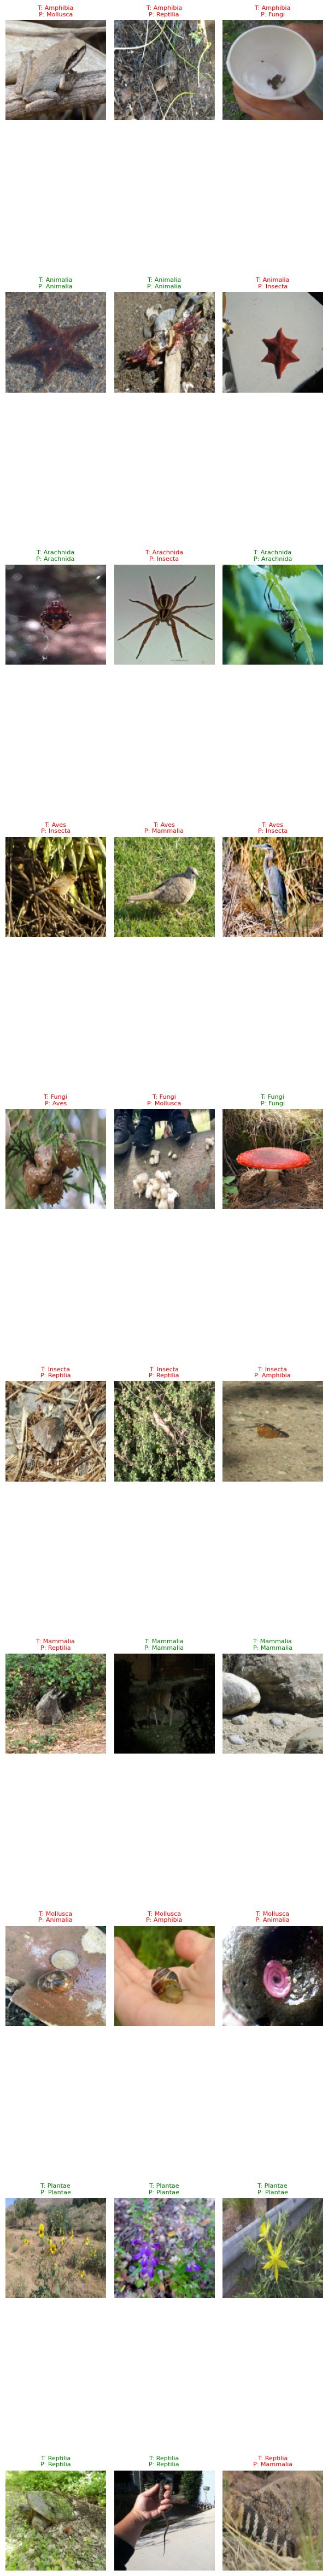

In [29]:

# Ensure model is in eval mode
model.eval()

# Get dataset and class info
test_dataset = test_loader.dataset
class_names = test_dataset.classes
num_classes = len(class_names)

# Collect indices of samples per class
class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(test_dataset.samples):
    class_indices[label].append(idx)

# Randomly pick 10 samples per class
samples_per_class = 10
selected_indices = []
for class_id in range(num_classes):
    if len(class_indices[class_id]) >= samples_per_class:
        selected_indices.extend(random.sample(class_indices[class_id], samples_per_class))

# Get selected samples
selected_images = []
true_labels = []
for idx in selected_indices:
    img, label = test_dataset[idx]
    selected_images.append(img)
    true_labels.append(label)

# Convert to tensor batch
batch = torch.stack(selected_images).to(device)
true_labels = torch.tensor(true_labels).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(batch)
_, pred_labels = outputs.max(1)

# Denormalize images (adjust mean/std if needed)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
denormalized = batch * std + mean
denormalized = torch.clamp(denormalized, 0, 1)





plt.figure(figsize=(20, 5 * num_classes))  # Adjust height dynamically
for class_id in range(num_classes):
    class_samples = [i for i, lbl in enumerate(true_labels) if lbl == class_id]
    for j, sample_idx in enumerate(class_samples[:3]):  # Show first 3 samples per class
        plt.subplot(num_classes, 10, class_id * 10 + j + 1)
        img = denormalized[sample_idx].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.axis('off')
        
        true_name = class_names[true_labels[sample_idx]]
        pred_name = class_names[pred_labels[sample_idx]]
        color = "green" if true_labels[sample_idx] == pred_labels[sample_idx] else "red"
        plt.title(f"T: {true_name}\nP: {pred_name}", color=color, fontsize=8)

plt.tight_layout()
plt.show()

# Save the figure to a temporary buffer (no physical file)
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
buf.seek(0)
img = Image.open(buf)

# Log to wandb
wandb.log({
    "Predictions (3 per class)": wandb.Image(img, caption="3 samples per class")
})

# Close the figure to free memory
plt.close(fig)
buf.close()
wandb.finish()

In [30]:
plt.savefig("predictions_per_class.png", bbox_inches="tight", dpi=150)

<Figure size 640x480 with 0 Axes>

In [31]:
wandb.log({"Predictions (3 per class)": wandb.Image(plt)})

<Figure size 640x480 with 0 Axes>